In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
path_inception = f"{getcwd()}/temp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (75, 75, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  # Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization_v1[0][0]     
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.80):
      print("\nReached 90.0% accuracy so cancelling training!")
      self.model.stop_training = True


In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (7, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization_v1[0][0]     
______________________________________________________________________________________________

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'temp2/images/train'
validation_dir = 'temp2/images/validation'

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    # Your Code Here
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 75,
                                                    class_mode = 'categorical', 
                                                    target_size = (75, 75))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 75,
                                                          class_mode  = 'categorical', 
                                                          target_size = (75, 75))



Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy

callbacks = myCallback()
history = model.fit_generator(train_generator,
                            validation_data = validation_generator,
                            steps_per_epoch = 400,
                            epochs = 100,
                            validation_steps = 110,
                            verbose = 2,
                            callbacks=[callbacks])

Epoch 1/100
400/400 - 530s - loss: 1.6144 - acc: 0.3733 - val_loss: 7.4724 - val_acc: 0.2736
Epoch 2/100
400/400 - 442s - loss: 1.5992 - acc: 0.3800 - val_loss: 8.0354 - val_acc: 0.3503
Epoch 3/100
400/400 - 439s - loss: 1.5907 - acc: 0.3848 - val_loss: 8.4263 - val_acc: 0.3025
Epoch 4/100
400/400 - 443s - loss: 1.5784 - acc: 0.3919 - val_loss: 7.5768 - val_acc: 0.3409
Epoch 5/100
400/400 - 435s - loss: 1.5800 - acc: 0.3867 - val_loss: 11.1872 - val_acc: 0.2770
Epoch 6/100
400/400 - 423s - loss: 1.5699 - acc: 0.3965 - val_loss: 8.6375 - val_acc: 0.3469
Epoch 7/100
400/400 - 1261s - loss: 1.5645 - acc: 0.3963 - val_loss: 14.7259 - val_acc: 0.3050
Epoch 8/100
400/400 - 452s - loss: 1.5600 - acc: 0.3999 - val_loss: 15.3283 - val_acc: 0.3161
Epoch 9/100
400/400 - 315s - loss: 1.5624 - acc: 0.4029 - val_loss: 17.7557 - val_acc: 0.3321
Epoch 10/100
400/400 - 318s - loss: 1.5632 - acc: 0.3983 - val_loss: 22.2015 - val_acc: 0.3381
Epoch 11/100
400/400 - 319s - loss: 1.5667 - acc: 0.3972 - val_

Epoch 87/100
400/400 - 354s - loss: 1.5708 - acc: 0.4092 - val_loss: 306.4716 - val_acc: 0.3143
Epoch 88/100
400/400 - 349s - loss: 1.5475 - acc: 0.4204 - val_loss: 312.4553 - val_acc: 0.3164
Epoch 89/100
400/400 - 350s - loss: 1.5703 - acc: 0.4098 - val_loss: 302.5898 - val_acc: 0.3175
Epoch 90/100
400/400 - 359s - loss: 1.5638 - acc: 0.4078 - val_loss: 325.0438 - val_acc: 0.3120
Epoch 91/100
400/400 - 485s - loss: 1.5743 - acc: 0.4048 - val_loss: 322.0824 - val_acc: 0.3117
Epoch 92/100
400/400 - 518s - loss: 1.5697 - acc: 0.4088 - val_loss: 339.9540 - val_acc: 0.3119
Epoch 93/100
400/400 - 507s - loss: 1.5551 - acc: 0.4120 - val_loss: 340.8644 - val_acc: 0.3099
Epoch 94/100
400/400 - 451s - loss: 1.5664 - acc: 0.4144 - val_loss: 340.2847 - val_acc: 0.3132
Epoch 95/100
400/400 - 452s - loss: 1.5717 - acc: 0.4070 - val_loss: 342.6527 - val_acc: 0.3131
Epoch 96/100
400/400 - 444s - loss: 1.5689 - acc: 0.4123 - val_loss: 347.6914 - val_acc: 0.3181
Epoch 97/100
400/400 - 445s - loss: 1.57

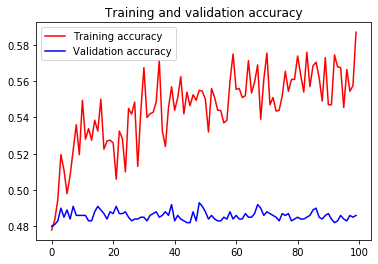

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)